In [1]:
import os
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib import pyplot
import japanize_matplotlib
%matplotlib inline

import lightgbm as lgbm
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import shap

#notebook内でJavascriptを動かすためのおまじない
shap.initjs()

import my_function

In [2]:
# sns.histplot 対応しているか(0.11.0以上)
print(sns.__version__)

0.11.1


In [3]:
INPUT_DIR = "./input"

In [4]:
train_df = pd.read_csv(os.path.join(INPUT_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(INPUT_DIR, "test.csv"))

In [5]:
whole_df = pd.concat([train_df,test_df], axis=0)

In [6]:
whole_df.head().T

0  \
PassengerId                        1   
Survived                           0   
Pclass                             3   
Name         Braund, Mr. Owen Harris   
Sex                             male   
Age                               22   
SibSp                              1   
Parch                              0   
Ticket                     A/5 21171   
Fare                            7.25   
Cabin                            NaN   
Embarked                           S   

                                                             1  \
PassengerId                                                  2   
Survived                                                     1   
Pclass                                                       1   
Name         Cumings, Mrs. John Bradley (Florence Briggs Th...   
Sex                                                     female   
Age                                                         38   
SibSp                                                        1   
Parch                                                        0   
Ticket                                                PC 17599   
Fare                                                   71.2833   
Cabin                                                      C85   
Embarked                                                     C   

                                  2  \
PassengerId                       3   
Survived                          1   
Pclass                            3   
Name         Heikkinen, Miss. Laina   
Sex                          female   
Age                              26   
SibSp                             0   
Parch                             0   
Ticket             STON/O2. 3101282   
Fare                          7.925   
Cabin                           NaN   
Embarked                          S   

                                                        3  \
PassengerId                                             4   
Survived                                                1   
Pclass                                                  1   
Name         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
Sex                                                female   
Age                                                    35   
SibSp                                                   1   
Parch                                                   0   
Ticket                                             113803   
Fare                                                 53.1   
Cabin                                                C123   
Embarked                                                S   

                                    4  
PassengerId                         5  
Survived                            0  
Pclass                              3  
Name         Allen, Mr. William Henry  
Sex                              male  
Age                                35  
SibSp                               0  
Parch                               0  
Ticket                         373450  
Fare                             8.05  
Cabin                             NaN  
Embarked                            S

<AxesSubplot:>

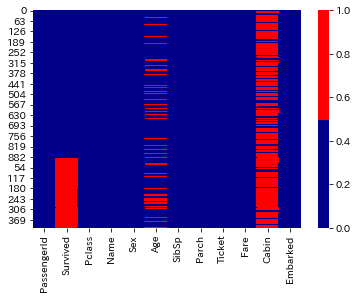

In [7]:
sns.heatmap(whole_df.isnull(), cmap=sns.color_palette(["darkblue", "red"]))

In [8]:
for col in whole_df.columns:
    missing_ratio = np.mean(whole_df[col].isnull())
    print(f"{col} - {round(missing_ratio*100, 0):.0f}%")

PassengerId - 0%
Survived - 32%
Pclass - 0%
Name - 0%
Sex - 0%
Age - 20%
SibSp - 0%
Parch - 0%
Ticket - 0%
Fare - 0%
Cabin - 77%
Embarked - 0%


<AxesSubplot:xlabel='Fare', ylabel='Survived'>

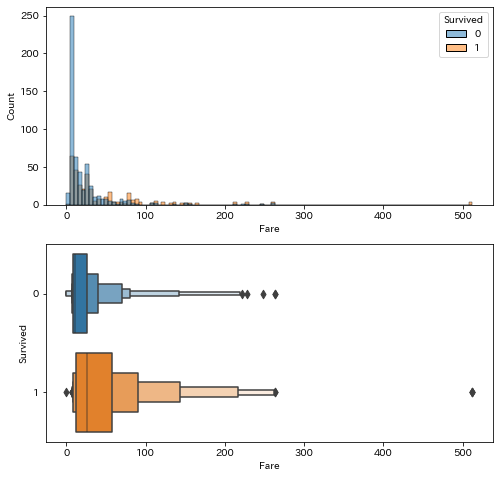

In [9]:
fig, axes = plt.subplots(figsize=(8,8), nrows=2)
sns.histplot(data=train_df, x="Fare", ax=axes[0], hue="Survived")
sns.boxenplot(data=train_df, x="Fare", y="Survived", orient="h", ax=axes[1]) 

<AxesSubplot:xlabel='Age', ylabel='Count'>

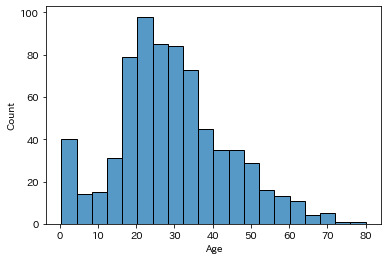

In [10]:
sns.histplot(train_df["Age"])

<AxesSubplot:xlabel='Age_Sex', ylabel='Pclass'>

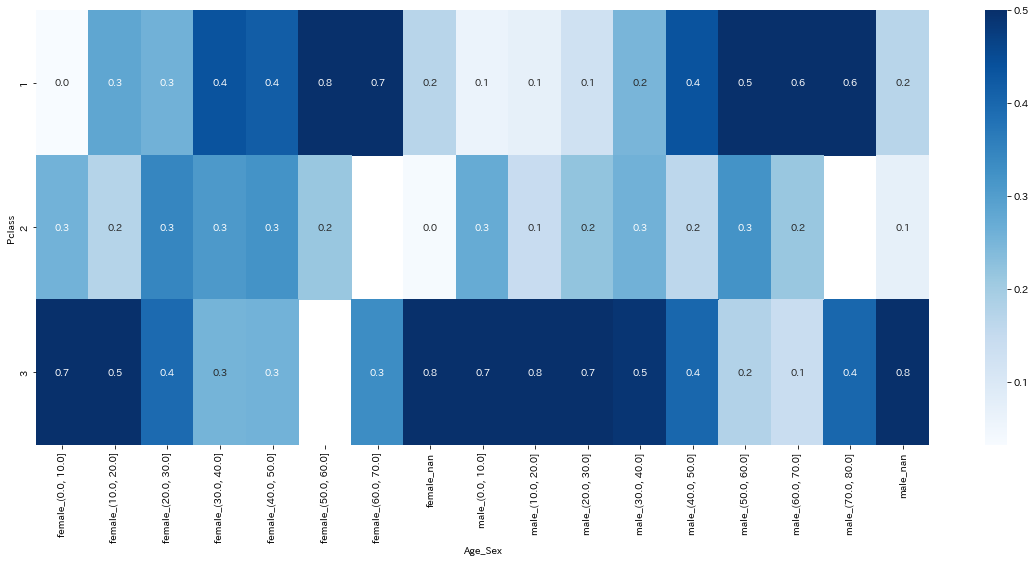

In [11]:
train_tmp_df = train_df.copy()
train_tmp_df["Age_bin"] = pd.cut(train_tmp_df["Age"], bins=np.linspace(0,80,8+1))

train_tmp_df["Age_Sex"] = train_tmp_df["Sex"] + "_" + train_tmp_df["Age_bin"].astype(str) 

_df = pd.pivot_table(data=train_tmp_df, 
                      index='Pclass', 
                      columns='Age_Sex', 
                      values='PassengerId', 
                      aggfunc='size')

# カラムごとの割合（縦で足すと100%）
_df = _df.div(_df.sum(axis=0), axis=1)

# ヒートマップ
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(_df, # 対象dfを指定（pivot_tableしたものを使うことが多い）
            ax=ax,  # plt.subplotsの都合上、設定している
            cmap='Blues',  # 色合い
            annot=True,  # 値を記載するか
            fmt='.1f',   # 値の小数点は何桁まで記載するか
            vmax=.5 
            )

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

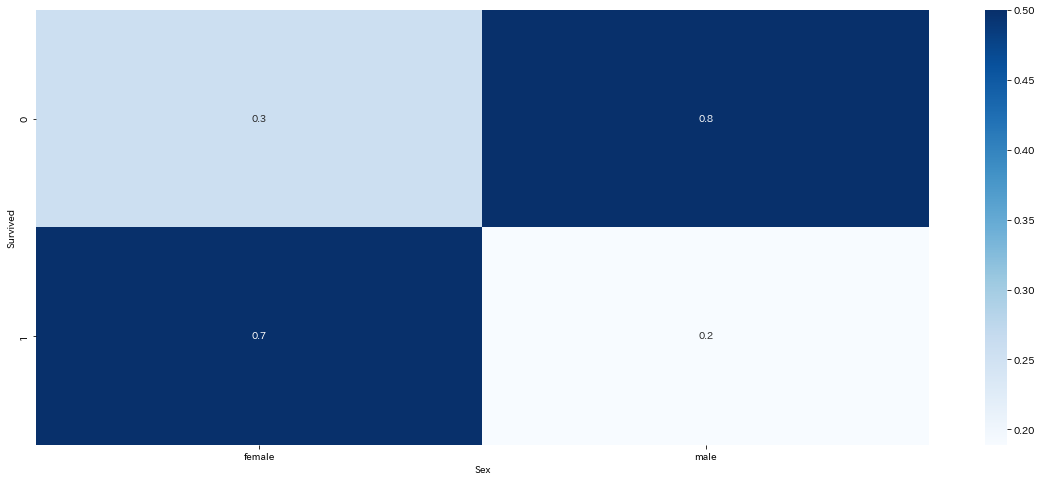

In [12]:
_df = pd.pivot_table(data=train_df, 
                      index='Survived', 
                      columns='Sex', 
                      values='PassengerId', 
                      aggfunc='size')

# カラムごとの割合（縦で足すと100%）
_df = _df.div(_df.sum(axis=0), axis=1)

# ヒートマップ
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(_df, # 対象dfを指定（pivot_tableしたものを使うことが多い）
            ax=ax,  # plt.subplotsの都合上、設定している
            cmap='Blues',  # 色合い
            annot=True,  # 値を記載するか
            fmt='.1f',   # 値の小数点は何桁まで記載するか
            vmax=.5 
            )

<AxesSubplot:xlabel='Age_Sex', ylabel='Survived'>

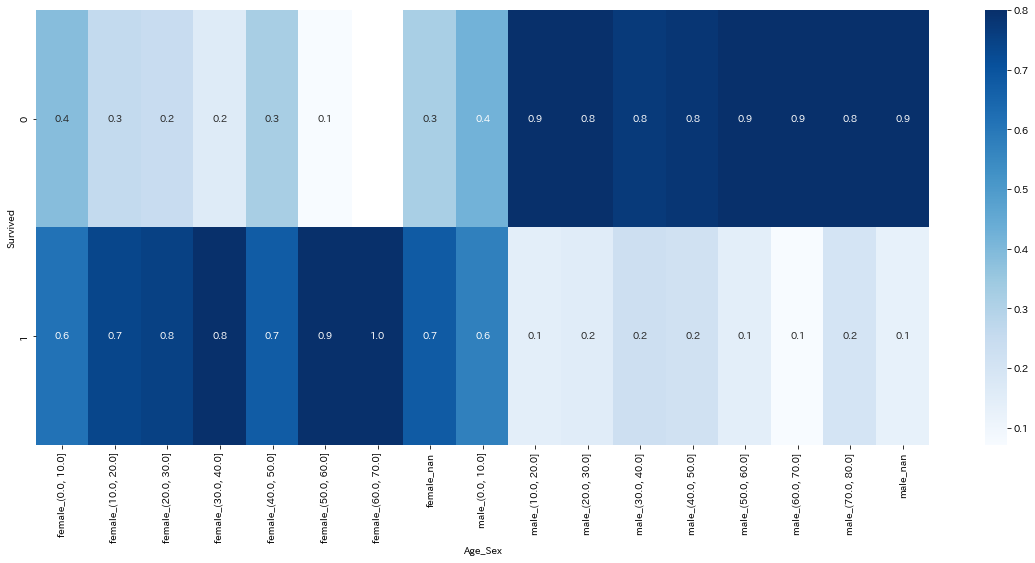

In [13]:
_df = pd.pivot_table(data=train_tmp_df, 
                      index='Survived', 
                      columns='Age_Sex', 
                      values='PassengerId', 
                      aggfunc='size')

# カラムごとの割合（縦で足すと100%）
_df = _df.div(_df.sum(axis=0), axis=1)

# ヒートマップ
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(_df, # 対象dfを指定（pivot_tableしたものを使うことが多い）
            ax=ax,  # plt.subplotsの都合上、設定している
            cmap='Blues',  # 色合い
            annot=True,  # 値を記載するか
            fmt='.1f',   # 値の小数点は何桁まで記載するか
            vmax=.8 
            )

# define model

In [14]:
whole_df = whole_df.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

In [15]:
whole_df = pd.get_dummies(whole_df,columns=["Sex","Embarked"])

In [16]:
# # 上記のようにOne-Hotせず、ラベルエンコードすることもできる
# df.Sex = pd.Categorical(df.Sex)
# df.Embarked = pd.Categorical(df.Embarked)

# df["Sex"] = df.Sex.cat.codes
# df["Embarked"] = df.Embarked.cat.codes

In [17]:
# # 家族人数を追加（精度下がったのでよろしくない）
# whole_df['FamilySize'] = whole_df['SibSp'] + whole_df['Parch'] + 1
# whole_df.loc[whole_df['FamilySize']>=8, 'FamilySize'] = 8

In [18]:
tr_df = whole_df.iloc[:len(train_df)]
ts_df = whole_df.iloc[len(train_df):]

In [19]:
tr_df.head().T

0        1       2     3      4
Survived     0.00   1.0000   1.000   1.0   0.00
Pclass       3.00   1.0000   3.000   1.0   3.00
Age         22.00  38.0000  26.000  35.0  35.00
SibSp        1.00   1.0000   0.000   1.0   0.00
Parch        0.00   0.0000   0.000   0.0   0.00
Fare         7.25  71.2833   7.925  53.1   8.05
Sex_female   0.00   1.0000   1.000   1.0   0.00
Sex_male     1.00   0.0000   0.000   0.0   1.00
Embarked_C   0.00   1.0000   0.000   0.0   0.00
Embarked_Q   0.00   0.0000   0.000   0.0   0.00
Embarked_S   1.00   0.0000   1.000   1.0   1.00

In [20]:
feat_df = tr_df.drop("Survived", axis=1)
target_df = tr_df["Survived"]

In [21]:
# do_shap=True でcvの各model出力の平均shap値も出力
oof_pred, models, shap_values, expected_values = my_function.fit_lgbm(feat_df, target_df, do_shap=True)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.406621
Fold1 AUC: 0.8673
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.457072
Fold2 AUC: 0.8375
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.418689
Fold3 AUC: 0.8792
FINISHED!!! whole score: 0.8595


(<Figure size 576x432 with 1 Axes>,
 <AxesSubplot:xlabel='feature_importance', ylabel='column'>)

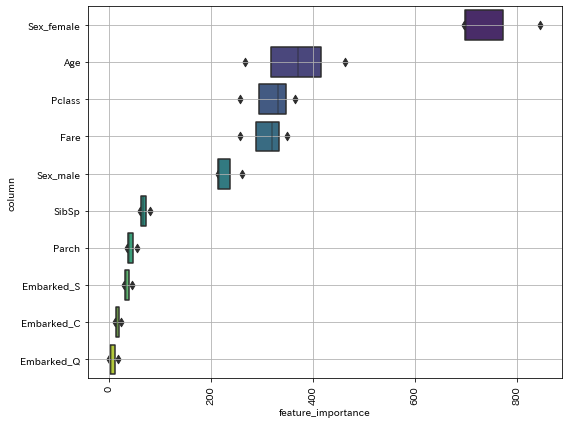

In [22]:
my_function.visualize_importance(models, feat_df)

In [23]:
ts_df = ts_df.drop("Survived", axis=1)

In [24]:
pred = my_function.create_predict(models, ts_df)

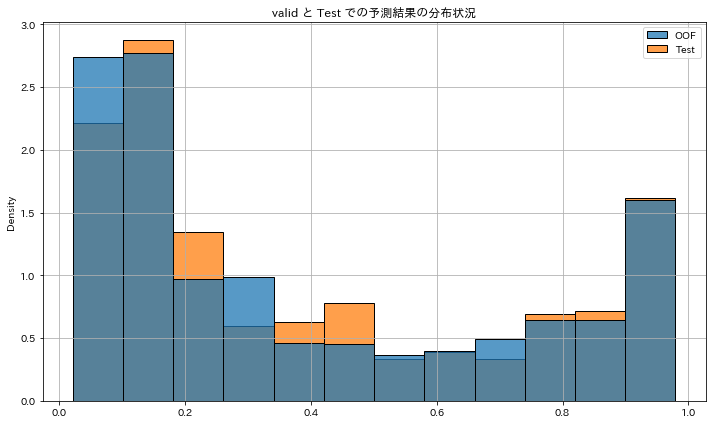

In [25]:
fig, ax = my_function.valid_test_density_plot(oof_pred, pred)

AUC: 0.8595399397096262


(<Figure size 432x432 with 1 Axes>, <AxesSubplot:>)

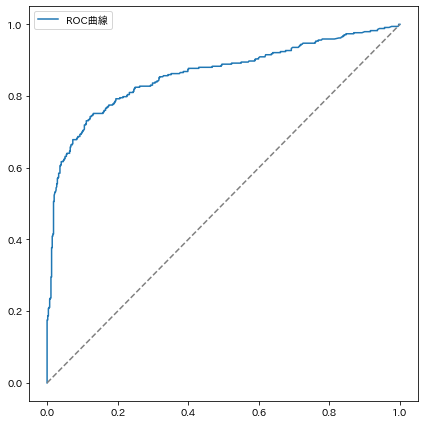

In [26]:
my_function.roc_curve_plot(target_df.values, oof_pred)

(<Figure size 864x432 with 12 Axes>, <AxesSubplot:title={'center':'Embarked'}>)

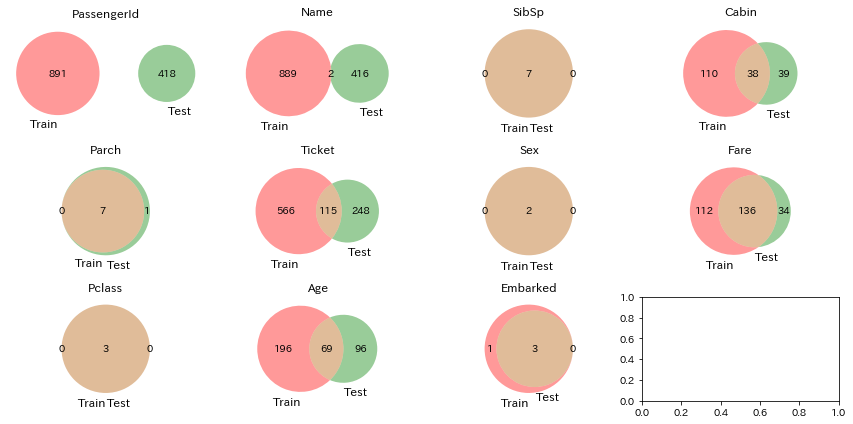

In [27]:
my_function.right_left_insersection(train_df,test_df, columns="__all__", set_labels=["Train", "Test"])

In [28]:
my_function.savefig(fig, "sample_fig", "./" )

save to ./sample_fig.png .


In [29]:
gender_sub_df = pd.read_csv(os.path.join(INPUT_DIR, "gender_submission.csv"))

In [30]:
gender_sub_df["Survived"] = np.where(pred>0.5,1,0)

<AxesSubplot:xlabel='Survived', ylabel='count'>

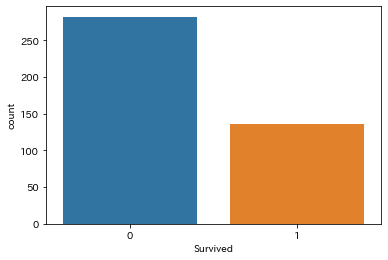

In [31]:
sns.countplot(gender_sub_df["Survived"])

<AxesSubplot:ylabel='Count'>

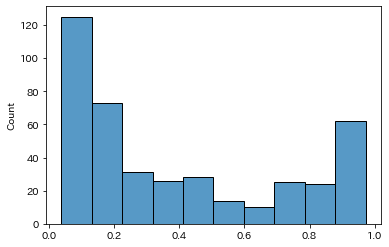

In [32]:
sns.histplot(pred)

In [33]:
gender_sub_df.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

In [34]:
gender_sub_df.to_csv("submission_01.csv", index=False)

In [35]:
with open("model.pickle", mode="wb") as fp:
    pickle.dump(models, fp)

In [36]:
with open("model.pickle", mode="rb") as fp:
    clf = pickle.load(fp)

In [37]:
clf

[LGBMClassifier(colsample_bytree=0.7, importance_type='gain', max_depth=6,
                n_estimators=1000, objective='binary'),
 LGBMClassifier(colsample_bytree=0.7, importance_type='gain', max_depth=6,
                n_estimators=1000, objective='binary'),
 LGBMClassifier(colsample_bytree=0.7, importance_type='gain', max_depth=6,
                n_estimators=1000, objective='binary')]

# SHAP

In [38]:
# 正ラベル（１）のときのshap値
shap_values[1].shape

(891, 10)

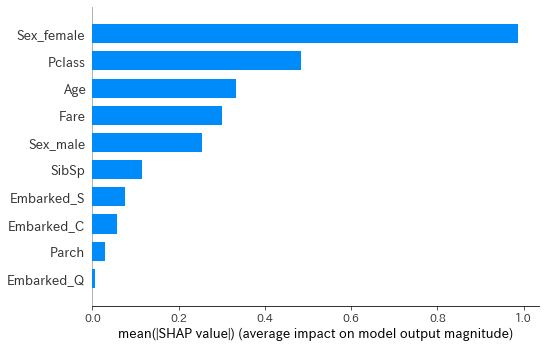

In [39]:
shap.summary_plot(shap_values[1], feat_df, plot_type="bar")

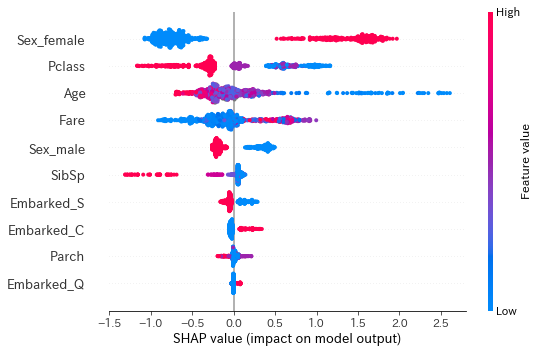

In [40]:
shap.summary_plot(shap_values[1], feat_df, plot_type="dot")

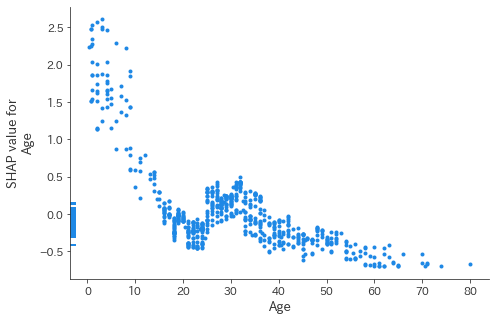

In [41]:
shap.dependence_plot("Age", shap_values[1], feat_df, interaction_index=None)

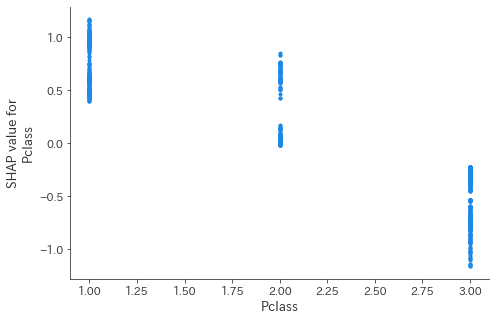

In [42]:
shap.dependence_plot("Pclass", shap_values[1], feat_df, interaction_index=None)

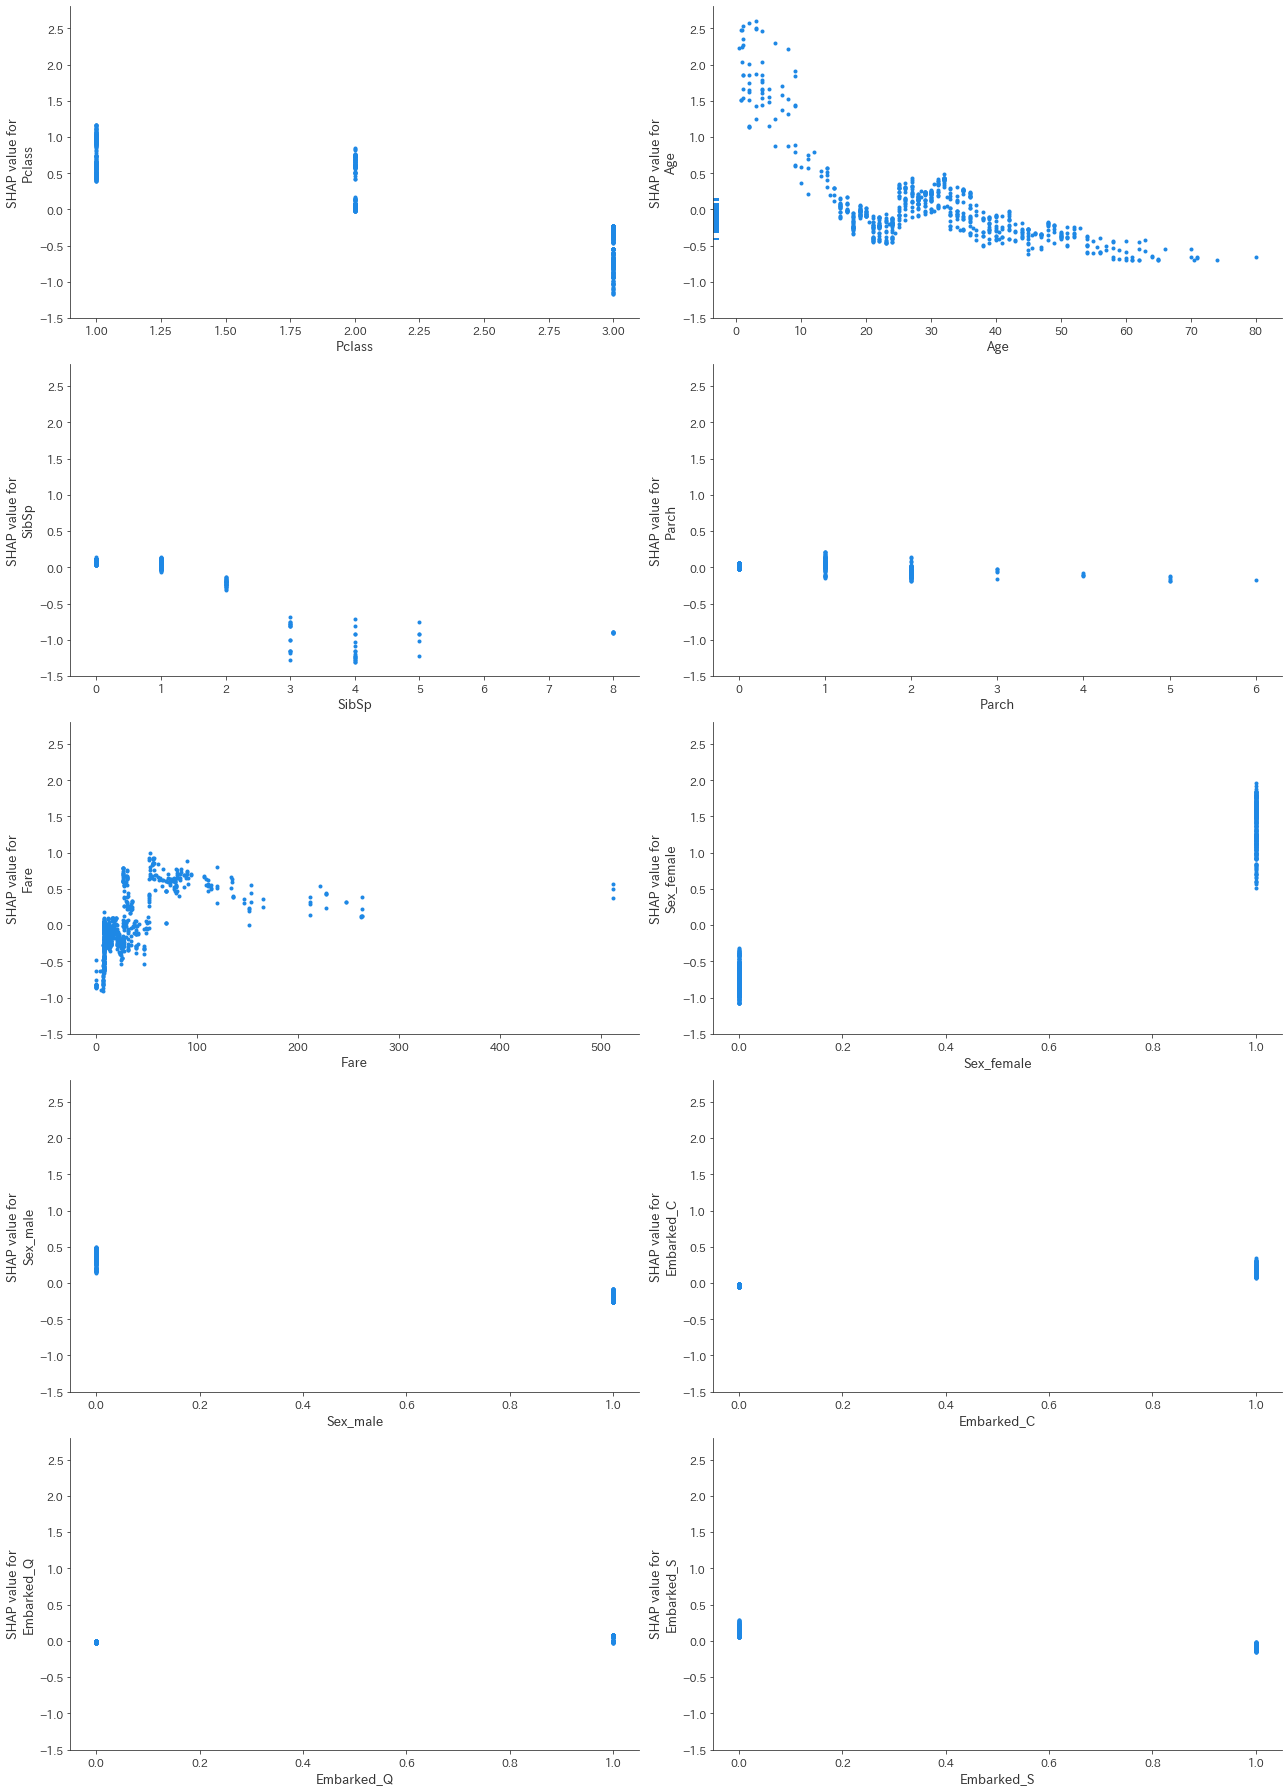

In [43]:
columns = list(feat_df.columns)
nfigs = len(columns)
ncols = 2  # Notebookの使える幅によって調整
nrows = - (- nfigs//ncols) # 切り上げ処理
fig, axes = plt.subplots(figsize=(9*ncols, 5*nrows), ncols=ncols, nrows=nrows, sharey=True)
axes = np.ravel(axes) # １次元にして、うまくfor文でplotできるように

for column, ax in zip(columns, axes):
    shap.dependence_plot(column, shap_values[1], feat_df, interaction_index=None, show=False, ax=ax)
fig.tight_layout()

In [44]:
train_df.head().T

0  \
PassengerId                        1   
Survived                           0   
Pclass                             3   
Name         Braund, Mr. Owen Harris   
Sex                             male   
Age                               22   
SibSp                              1   
Parch                              0   
Ticket                     A/5 21171   
Fare                            7.25   
Cabin                            NaN   
Embarked                           S   

                                                             1  \
PassengerId                                                  2   
Survived                                                     1   
Pclass                                                       1   
Name         Cumings, Mrs. John Bradley (Florence Briggs Th...   
Sex                                                     female   
Age                                                         38   
SibSp                                                        1   
Parch                                                        0   
Ticket                                                PC 17599   
Fare                                                   71.2833   
Cabin                                                      C85   
Embarked                                                     C   

                                  2  \
PassengerId                       3   
Survived                          1   
Pclass                            3   
Name         Heikkinen, Miss. Laina   
Sex                          female   
Age                              26   
SibSp                             0   
Parch                             0   
Ticket             STON/O2. 3101282   
Fare                          7.925   
Cabin                           NaN   
Embarked                          S   

                                                        3  \
PassengerId                                             4   
Survived                                                1   
Pclass                                                  1   
Name         Futrelle, Mrs. Jacques Heath (Lily May Peel)   
Sex                                                female   
Age                                                    35   
SibSp                                                   1   
Parch                                                   0   
Ticket                                             113803   
Fare                                                 53.1   
Cabin                                                C123   
Embarked                                                S   

                                    4  
PassengerId                         5  
Survived                            0  
Pclass                              3  
Name         Allen, Mr. William Henry  
Sex                              male  
Age                                35  
SibSp                               0  
Parch                               0  
Ticket                         373450  
Fare                             8.05  
Cabin                             NaN  
Embarked                            S

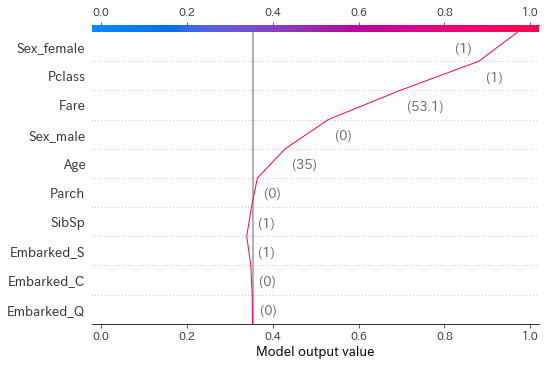

In [45]:
idx = 3

shap.initjs()
shap.decision_plot(expected_values[1], shap_values[1][idx], feat_df.iloc[idx,:],link="logit")

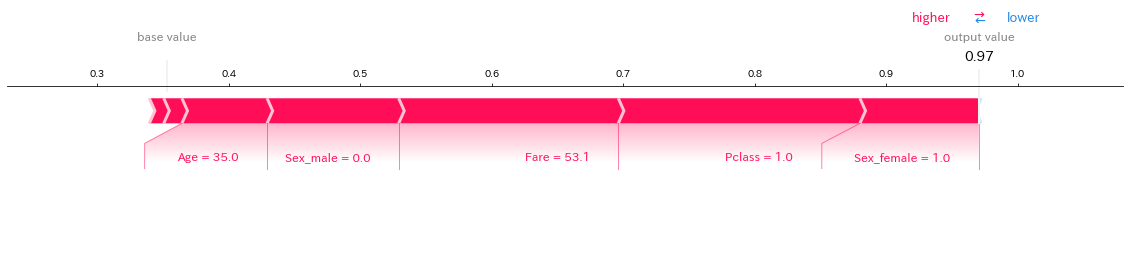

In [46]:
# 背景黒の場合は、 matplotlib=True 入れると白地になる
shap.force_plot(expected_values[1], shap_values[1][idx], feat_df.iloc[idx,:],link="logit", matplotlib=True)

In [47]:
oof_pred[idx]

0.9654071581126907

### 予測を間違えたサンプルを取ってきて、確認するとよさそう

In [48]:
# しきい値: 0.5
misclassified = (np.round(oof_pred) != target_df.values)

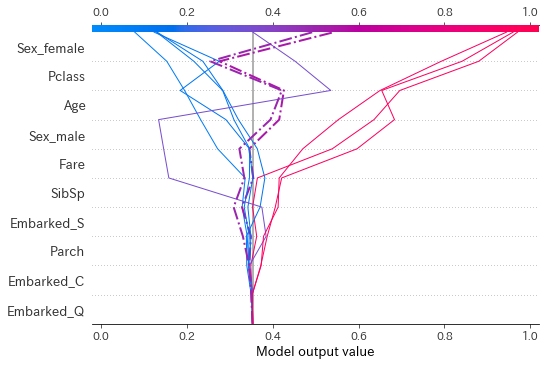

In [49]:
# 予測を間違えたサンプルは「破線」で表現（ highlight 引数）
shap.decision_plot(expected_values[1], shap_values[1][0:10],feat_df.iloc[0:10,:],link="logit",highlight=misclassified[0:10])

In [50]:
misclassified[:10]

array([False, False,  True, False, False, False, False, False,  True,
       False])

In [51]:
train_df.iloc[2]

PassengerId                         3
Survived                            1
Pclass                              3
Name           Heikkinen, Miss. Laina
Sex                            female
Age                                26
SibSp                               0
Parch                               0
Ticket               STON/O2. 3101282
Fare                            7.925
Cabin                             NaN
Embarked                            S
Name: 2, dtype: object

In [52]:
oof_pred[2]

0.4716014665586186

expected_values とは何か？
- 予測の平均値を表し、base_valueとなる
- ,link="logit" とすると、確率値に収まるので、見えているbase_valueの値は変わる

In [53]:
expected_values[1]

-0.6061903765831606